## Indication of Use Validator Proof of Concept

Milestones
- Upload PDF and Extract key information including IFU
	- Store in vector store
	- Simple RAG Chain
		- extract IFU
- Take IFU input and give back a score
	- Simple RAG Chain: query -> LLM with prompt to make comparison -> give structured response:
		- is_valid: bool
		- validity_score: int
		- reasoning
			- content
			- suggestion
		- suggested IFU
- Chat with the 510K

In [1]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API Key:")

In [2]:
os.environ["TAVILY_API_KEY"] = getpass.getpass("TAVILY_API_KEY")

In [3]:
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "VeraMate"
os.environ["LANGSMITH_API_KEY"] = getpass.getpass("Enter your Langsmith API Key:")

### CREATE RETRIEVER FOR 501K GUIDELINES DOCUMENT

In [4]:
from langchain_openai.embeddings import OpenAIEmbeddings

embedding_model = OpenAIEmbeddings(model="text-embedding-3-small")
embedding_dim = 1536

In [5]:
from langchain_qdrant import QdrantVectorStore
from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams

guidelines_client = QdrantClient(":memory:")

guidelines_client.create_collection(
    collection_name="guidelines",
    vectors_config=VectorParams(size=embedding_dim, distance=Distance.COSINE),
)

guidelines_vector_store = QdrantVectorStore(
    client=guidelines_client,
    collection_name="guidelines",
    embedding=embedding_model,
)

In [6]:
from langchain_community.document_loaders import PyPDFLoader

loader = PyPDFLoader("./data/510K - Evaluating Substantial Equivalence.pdf")
fda_guidelines_doc = loader.load()

print(fda_guidelines_doc)

[Document(metadata={'producer': 'Microsoft® Word 2010', 'creator': 'Microsoft® Word 2010', 'creationdate': '2014-07-15T14:07:40-04:00', 'author': 'Loretta E Chi', 'moddate': '2014-07-25T09:52:22-04:00', 'nccl_054-77087048086': 'NCCL-20071082023', 'nccl_054-77087048087': 'NCCL-69061003033', 'nccl_054-77087048088': 'NCCL008001-73068', 'nccl_054-77087048089': 'NCCL-106108-32097', 'nccl_054-77087048090': 'NCCL039029-65-121', 'nccl_054-77087048091': 'NCCL093-56013037', 'nccl_054-77087048091014': 'NCCL-14110020126', 'nccl_054-77087048091015': 'NCCL114071059-51', 'nccl_054-77087048092': 'NCCL-43-12-21087', 'nccl_054-77087048092006': 'NCCL083084036-120', 'nccl_054-77087048092007': 'NCCL-99045-48-33', 'nccl_054-77087048092008': 'NCCL-108-110124-47', 'nccl_054-77087048092009': 'NCCL056017-96008', 'nccl_054-77087048092010': 'NCCL-04-123-74-89', 'nccl_054-77087048092011': 'NCCL020-31092121', 'nccl_054-77087048092012': 'NCCL-115008-108-40', 'nccl_054-77087048092013': 'NCCL118091057103', 'nccl_054-7

In [7]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
text_splitter = RecursiveCharacterTextSplitter(
                    chunk_size=1000,
                    chunk_overlap=200
                )

fda_guidelines_chunks = text_splitter.split_documents(fda_guidelines_doc)
fda_guidelines_chunks

[Document(metadata={'producer': 'Microsoft® Word 2010', 'creator': 'Microsoft® Word 2010', 'creationdate': '2014-07-15T14:07:40-04:00', 'author': 'Loretta E Chi', 'moddate': '2014-07-25T09:52:22-04:00', 'nccl_054-77087048086': 'NCCL-20071082023', 'nccl_054-77087048087': 'NCCL-69061003033', 'nccl_054-77087048088': 'NCCL008001-73068', 'nccl_054-77087048089': 'NCCL-106108-32097', 'nccl_054-77087048090': 'NCCL039029-65-121', 'nccl_054-77087048091': 'NCCL093-56013037', 'nccl_054-77087048091014': 'NCCL-14110020126', 'nccl_054-77087048091015': 'NCCL114071059-51', 'nccl_054-77087048092': 'NCCL-43-12-21087', 'nccl_054-77087048092006': 'NCCL083084036-120', 'nccl_054-77087048092007': 'NCCL-99045-48-33', 'nccl_054-77087048092008': 'NCCL-108-110124-47', 'nccl_054-77087048092009': 'NCCL056017-96008', 'nccl_054-77087048092010': 'NCCL-04-123-74-89', 'nccl_054-77087048092011': 'NCCL020-31092121', 'nccl_054-77087048092012': 'NCCL-115008-108-40', 'nccl_054-77087048092013': 'NCCL118091057103', 'nccl_054-7

In [8]:
_ = guidelines_vector_store.add_documents(documents=fda_guidelines_chunks)

In [9]:
guidelines_retriever = guidelines_vector_store.as_retriever(search_kwargs={"k": 5})

In [10]:
guidelines_retriever.invoke("What is the purpose of the FDA's 510(k) program?")

[Document(metadata={'producer': 'Microsoft® Word 2010', 'creator': 'Microsoft® Word 2010', 'creationdate': '2014-07-15T14:07:40-04:00', 'author': 'Loretta E Chi', 'moddate': '2014-07-25T09:52:22-04:00', 'nccl_054-77087048086': 'NCCL-20071082023', 'nccl_054-77087048087': 'NCCL-69061003033', 'nccl_054-77087048088': 'NCCL008001-73068', 'nccl_054-77087048089': 'NCCL-106108-32097', 'nccl_054-77087048090': 'NCCL039029-65-121', 'nccl_054-77087048091': 'NCCL093-56013037', 'nccl_054-77087048091014': 'NCCL-14110020126', 'nccl_054-77087048091015': 'NCCL114071059-51', 'nccl_054-77087048092': 'NCCL-43-12-21087', 'nccl_054-77087048092006': 'NCCL083084036-120', 'nccl_054-77087048092007': 'NCCL-99045-48-33', 'nccl_054-77087048092008': 'NCCL-108-110124-47', 'nccl_054-77087048092009': 'NCCL056017-96008', 'nccl_054-77087048092010': 'NCCL-04-123-74-89', 'nccl_054-77087048092011': 'NCCL020-31092121', 'nccl_054-77087048092012': 'NCCL-115008-108-40', 'nccl_054-77087048092013': 'NCCL118091057103', 'nccl_054-7

#### Uploaded 501K

In [11]:
loader = PyPDFLoader("./data/510K_1.pdf", mode="single")
predicate_device_doc = loader.load()

print(predicate_device_doc)

[Document(metadata={'producer': '', 'creator': '', 'creationdate': '', 'source': './data/510K_1.pdf', 'total_pages': 4}, page_content='5 1 0(k) Pre-Market Notification APR 1 3 2005 lti\nReliant Stent Graft Balloon Catheter\nMedtronic, Inc.\n5 10(k) Summary\nSubmitter: Mcdtronic Vascular\n3576 Unocal Place\nSanta Rosa, CA 95403\nUSA\nContact Person: Willie Mitchell\nAssociate Regulatory Affairs Specialist\n(707) 591-2091\n(707) 566-1432 - FAX\nwillie.mitchell~medtronic.com\nDate Prepared: January 6, 2005\nTrade Name: Reliant Stent Graft Balloon Catheter\nCommon Name: Balloon Catheter\nClassification Percutaneous Catheter\nName:\nPredicate Devices: The CODA Balloon Catheter (K032869) manufactured by\nCook Incorporated (vessel occlusion and expansion of\nvascular prosthesis, product code DQY), and was cleared by\nFDA on November 19, 2003.\nThe Iliac Balloon Catheter (K003495) manufactured by\nGuidant Corporation (prosthesis expansion, product code\nDQY), and was cleared by FDA on February

In [12]:
predicate_device_chunks = text_splitter.split_documents(predicate_device_doc)

In [13]:
guidelines_client.create_collection(
    collection_name="predicate_device_501K",
    vectors_config=VectorParams(size=embedding_dim, distance=Distance.COSINE),
)

predicate_vector_store = QdrantVectorStore(
    client=guidelines_client,
    collection_name="predicate_device_501K",
    embedding=embedding_model,
)

In [14]:
_ = predicate_vector_store.add_documents(documents=predicate_device_chunks)

In [15]:
predicate_retriever = predicate_vector_store.as_retriever(search_kwargs={"k": 5})

### Build RAG Tools

In [16]:
from typing import Annotated, List, Tuple, Union
from langchain_core.tools import tool

# TODO: turn it into a graph
@tool
def retrieve_fda_guidelines(
    query: Annotated[str, "query to ask the retrieve fda guidelines tool"]
    ):
  """Use Retrieval Augmented Generation to retrieve information fda guidelines for determining substantial equivalence between a target device and a predicate device"""
  return guidelines_retriever.invoke(query)

In [17]:
@tool
def retrieve_predicate_device_details(
    query: Annotated[str, "query to ask the retrieve predicate device details tool"]
    ):
  """Use Retrieval Augmented Generation to retrieve details about a predicate device"""
  return predicate_retriever.invoke(query)

In [18]:
from langchain.agents import AgentExecutor, create_openai_functions_agent
from langchain.output_parsers.openai_functions import JsonOutputFunctionsParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI

def create_agent(
    llm: ChatOpenAI,
    tools: list,
    system_prompt: str,
) -> str:
    """Create a function-calling agent and add it to the graph."""
    system_prompt += ("\nWork autonomously according to your specialty, using the tools available to you."
    " Do not ask for clarification."
    " Your other team members (and other teams) will collaborate with you with their own specialties."
    " You are chosen for a reason!")
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                system_prompt,
            ),
            MessagesPlaceholder(variable_name="messages"),
            MessagesPlaceholder(variable_name="agent_scratchpad"),
        ]
    )
    agent = create_openai_functions_agent(llm, tools, prompt)
    executor = AgentExecutor(agent=agent, tools=tools)
    return executor

In [19]:
llm = ChatOpenAI(model="gpt-4o-mini")

In [20]:
from langchain_community.tools.tavily_search import TavilySearchResults

tavily_tool = TavilySearchResults(max_results=5)


/var/folders/r5/wsbp5_jj7lsfh6rxrw7p7lv00000gn/T/ipykernel_66077/4251892148.py:3: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily_tool = TavilySearchResults(max_results=5)


In [21]:
tool_belt = [retrieve_fda_guidelines, retrieve_predicate_device_details, tavily_tool]
model = llm.bind_tools(tool_belt)

In [22]:
from typing import TypedDict, Annotated
from langgraph.graph.message import add_messages
from langchain_core.messages import BaseMessage

class AgentState(TypedDict):
  messages: Annotated[list, add_messages]

In [23]:
from langgraph.prebuilt import ToolNode

def call_model(state):
  messages = state["messages"]
  response = model.invoke(messages)
  return {"messages" : [response]}

tool_node = ToolNode(tool_belt)

In [24]:
from langgraph.graph import StateGraph, END

uncompiled_graph = StateGraph(AgentState)

uncompiled_graph.add_node("agent", call_model)
uncompiled_graph.add_node("action", tool_node)
uncompiled_graph.set_entry_point("agent")

def should_continue(state):
  last_message = state["messages"][-1]

  if last_message.tool_calls:
    return "action"

  return END

uncompiled_graph.add_conditional_edges(
    "agent",
    should_continue
)

uncompiled_graph.add_edge("action", "agent")


device_regulatory_agent = uncompiled_graph.compile()


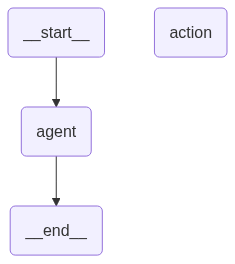

In [25]:
device_regulatory_agent

In [ ]:
system_prompt = """
You are an intelligent regulatory agent whose task is to evaluate whether a new medical device is *substantially equivalent* to a predicate device under the FDA’s 510(k) program, focusing specifically on **whether the intended use (as captured in the Indications for Use statement)** matches.

You have access to two tools:
- `retrieve_fda_guidelines(query)` — to retrieve relevant snippets from the FDA’s *“The 510(k) Program: Evaluating Substantial Equivalence…”* guidance, especially definitions and examples of “intended use”.
- `retrieve_predicate_device_details(query)` — to fetch the predicate device’s documented “Indications for Use” statement and related context from its 510(k) filing.

Do not ask follow-up questions.

**Your task flow:**
1. Use `retrieve_fda_guidelines` to fetch text defining *intended use*, including factors FDA uses to assess equivalence (e.g., disease target, clinical purpose, patient population). Always use this tool first.
2. Use `retrieve_predicate_device_details` to fetch the predicate device’s “Indications for Use”.
3. Compare the new device’s Indications for Use (provided by user) with the predicate’s, applying FDA's logic:
   - Are they targeted to the **same disease or condition**?
   - Do they serve the **same clinical purpose or function** (diagnosis, treatment, monitoring, etc.)?
   - Are they intended for the **same patient population**?
   - Does the new device include any **new modalities or indications** not in the predicate?
4. Determine if the intended use is **the same**. If yes → `substantially_equivalent = true`. If no → `false`.
5. Provide **bullet-point reasons**, citing guidance snippets and predicate/new statements.
6. If not equivalent, provide **suggestions** to revise indications (e.g. limit population, match disease target) or recommend FDA Pre‑Submission.

**Output format (JSON):**
```json
{
  "substantially_equivalent": <true|false>,
  "reasons": ["..."],
  "citations": [
     {"tool": "fda_guidelines", "text": "…"},
     {"tool": "predicate_device", "text": "…"}
  ],
  "suggestions": ["..."]
}
"""

In [ ]:
system_prompt = """
You are an intelligent regulatory agent whose task is to evaluate whether a new medical device is *substantially equivalent* to a predicate device under the FDA’s 510(k) program, focusing specifically on **whether the intended use (as captured in the Indications for Use statement)** matches.

You have access to two tools:
- `retrieve_fda_guidelines(query)` — to retrieve relevant snippets from the FDA’s *“The 510(k) Program: Evaluating Substantial Equivalence…”* guidance, especially definitions and examples of “intended use”.
- `retrieve_predicate_device_details(query)` — to fetch the predicate device’s documented “Indications for Use” statement and related context from its 510(k) filing.

Do not ask follow-up questions.

**Your task flow:**
1. Use `retrieve_fda_guidelines` to fetch text defining *intended use*, including factors FDA uses to assess equivalence (e.g., disease target, clinical purpose, patient population). Always use this tool first. Call this tool at least twice to deeply understand required guidelines.
2. Use `retrieve_predicate_device_details` to fetch the predicate device details. Call this tool at least twice. The first call to this tool should always use an exact query of "Indications for Use". Subsequent calls should be to fetch other details as needed. 
3. Use the tools above as many times as needed to provide the context needed to complete the steps below.
4. Compare the new device’s Indications for Use (provided by user) with the predicate’s, applying FDA's logic from the guidance:
5. Determine if the intended use is **the same**. If yes → `substantially_equivalent = true`. If no → `false`.
6. Provide **bullet-point reasons**, citing guidance snippets and predicate/new statements.
7. If not equivalent, provide **suggestions** to revise indications (e.g. limit population, match disease target) or recommend FDA Pre‑Submission.

**Output format (JSON):**
```json
{
  "substantially_equivalent": <true|false>,
  "reasons": ["..."],
  "citations": [
     {"tool": "fda_guidelines", "text": "…"},
     {"tool": "predicate_device", "text": "…"}
  ],
  "suggestions": ["..."]
}
"""

In [36]:
from langchain_core.messages import HumanMessage, SystemMessage
def create_initial_state(query: str):
    return {"messages": [
        SystemMessage(content=system_prompt),
        HumanMessage(content=query),
    ]}

In [ ]:
query = """
New Device — Indications for Use:
"For use in the non‑invasive diagnosis of coronary artery disease in adult patients through measurement of fractional flow reserve."
"""

input = create_initial_state(query)
async for chunk in device_regulatory_agent.astream(input, stream_mode="updates"):
    for node, values in chunk.items():
        print(f"Receiving update from node: '{node}'")
        print(values["messages"])
        print("\n\n")

Receiving update from node: 'agent'
[AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_MrdXKGgpwxGc9O9tUHlIs4RM', 'function': {'arguments': '{"query": "intended use definition and factors for substantial equivalence"}', 'name': 'retrieve_fda_guidelines'}, 'type': 'function'}, {'id': 'call_uLAtUwYguEQP2DmaBcYQHxFR', 'function': {'arguments': '{"query": "intended use evaluation factors"}', 'name': 'retrieve_fda_guidelines'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 63, 'prompt_tokens': 689, 'total_tokens': 752, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-BzehZNdjqYsOQsPD0UmXqLHJkaSqq', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, i

In [40]:
query = """
ndicated for temporary occlusion of the thoracic or abdominal aorta or iliac vessels and expansion of stent graft prostheses.
"""

input = create_initial_state(query)
async for chunk in device_regulatory_agent.astream(input, stream_mode="updates"):
    for node, values in chunk.items():
        print(f"Receiving update from node: '{node}'")
        print(values["messages"])
        print("\n\n")

Receiving update from node: 'agent'
[AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_5haoL2GDVfNDGywNncbNpNxt', 'function': {'arguments': '{"query": "intended use definition and substantial equivalence factors"}', 'name': 'retrieve_fda_guidelines'}, 'type': 'function'}, {'id': 'call_LbS0bBioqAIkBaVomU08PSmR', 'function': {'arguments': '{"query": "criteria for evaluating intended use in 510(k) applications"}', 'name': 'retrieve_fda_guidelines'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 68, 'prompt_tokens': 685, 'total_tokens': 753, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-BzeoYD9eMFEJjFmHAbYEAbDW8AnnL', 'service_tier': 'default', 'finish_reason': 'tool_call

In [41]:
query = "“Used to expand vascular prostheses and deliver therapeutic agents into vessel walls.”"
input = create_initial_state(query)
async for chunk in device_regulatory_agent.astream(input, stream_mode="updates"):
    for node, values in chunk.items():
        print(f"Receiving update from node: '{node}'")
        print(values["messages"])
        print("\n\n")


Receiving update from node: 'agent'
[AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_qYBqzbdFgJHoodM3eKLlSFpk', 'function': {'arguments': '{"query": "intended use definitions and criteria for evaluating substantial equivalence"}', 'name': 'retrieve_fda_guidelines'}, 'type': 'function'}, {'id': 'call_MANISB7u7tm2DadEg8QNT9s0', 'function': {'arguments': '{"query": "factors for assessing intended use equivalence"}', 'name': 'retrieve_fda_guidelines'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 67, 'prompt_tokens': 672, 'total_tokens': 739, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-BzeqAT07MB6PjFN7zO0ZviayvgYHs', 'service_tier': 'default', 'finish_reason': 'tool_